# Group Member

In [1]:
import pandas as pd
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./license/APMA4990-834091538ff1.json"

# Data Gathering and Preparation

## Data Pipeline

In [2]:
from google.cloud import bigquery
client = bigquery.Client()

In [3]:
query = (
    """
    SELECT pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,vendor_id,store_and_fwd_flag,
    EXTRACT (DATE FROM pickup_datetime) as date,
    EXTRACT (YEAR FROM pickup_datetime) as year,
    TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) as trip_duration
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    LIMIT 100000
    """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')

In [4]:
df.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,vendor_id,store_and_fwd_flag,date,year,trip_duration
0,2016-05-28 03:04:14+00:00,2016-05-28 03:24:03+00:00,-73.990921,40.719234,-73.873405,40.756737,1,8.10,1,N,2016-05-28,2016,1189
1,2016-02-23 15:28:58+00:00,2016-02-23 16:40:09+00:00,-73.818291,40.706432,-74.033928,40.720863,1,17.07,2,N,2016-02-23,2016,4271
2,2016-05-27 11:30:20+00:00,2016-05-27 12:06:21+00:00,-73.782135,40.644646,-73.959831,40.611912,1,16.80,1,N,2016-05-27,2016,2161
3,2016-02-14 13:50:25+00:00,2016-02-14 14:38:20+00:00,-73.790489,40.643917,-73.979950,40.642593,1,26.40,1,N,2016-02-14,2016,2875
4,2016-03-16 23:38:53+00:00,2016-03-17 00:22:37+00:00,-73.979179,40.759014,-73.831581,40.771317,1,12.20,1,N,2016-03-16,2016,2624


In [5]:
df.shape

(100000, 13)

## Data Integrity Check

 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **trip_distance** - the elapsed trip distance in miles reported by the taximeter
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

In [6]:
check_NAN_box = []

for i in df.columns:
    check_NAN_box.append(df[i].isnull().any())

check_NAN_box = pd.DataFrame([check_NAN_box],columns=df.columns)
check_NAN_box

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,vendor_id,store_and_fwd_flag,date,year,trip_duration
0,False,False,True,True,True,True,False,False,False,False,False,False,False


In [7]:
check_uni_box = []
col = ['passenger_count','vendor_id','store_and_fwd_flag','year']

for i in col:
    check_uni_box.append(df[i].unique())

check_uni_box = pd.DataFrame([check_uni_box],columns=col)
check_uni_box

,passenger_count,vendor_id,store_and_fwd_flag,year
0,"[1, 2, 5, 3, 4, 6, 0, 8, 7]","[1, 2, 3]","[N, Y]",[2016]


In [11]:
def preprocess(data):
    tmp = data[~data['pickup_longitude'].isnull()]
    tmp = tmp[~tmp['pickup_latitude'].isnull()]
    tmp = tmp[~tmp['dropoff_longitude'].isnull()]
    tmp = tmp[~tmp['dropoff_latitude'].isnull()]
    tmp = tmp[tmp['pickup_longitude']!=0.0]
    tmp = tmp[tmp['pickup_latitude']!=0.0]
    tmp = tmp[tmp['dropoff_longitude']!=0.0]
    tmp = tmp[tmp['dropoff_latitude']!=0.0]
    tmp = tmp[tmp['trip_distance']>0.0]
    tmp = tmp[tmp['passenger_count']>0]
    tmp = tmp[tmp['vendor_id'].isin(['1','2','3'])]
    tmp = tmp[tmp['store_and_fwd_flag'].isin(['Y','N'])]
    tmp = tmp[tmp['year']==2016] 
    return tmp

data = preprocess(df)

In [12]:
data.shape

(49486, 13)

## Feature Engineering

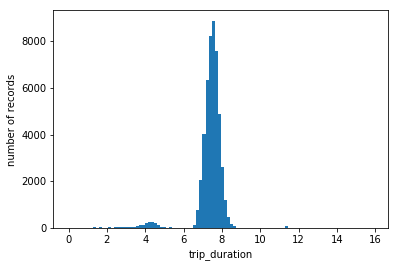

In [18]:
plt.hist(np.log(data['trip_duration'].values+1), bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

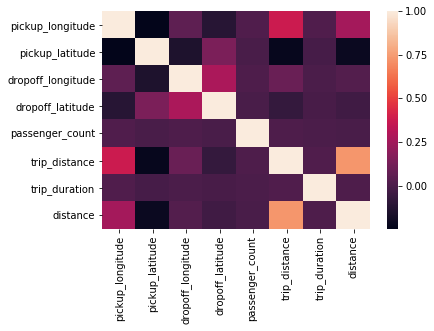

In [13]:
data = data.drop('year',axis=1)
data['distance'] = [pow((data['pickup_longitude'].loc[i]-data['dropoff_longitude'].loc[i]),2)+pow((data['pickup_latitude'].loc[i]-data['dropoff_latitude'].loc[i]),2) for i in data.index]
corr = data.corr()
sns.heatmap(corr)

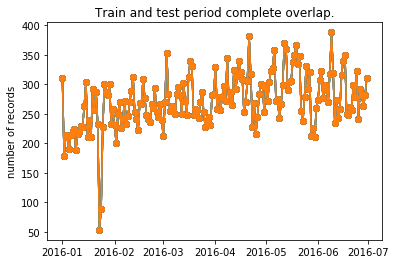

In [21]:
plt.plot(data.groupby('date').count(), 'o-')
plt.title('Trip frequency')
plt.ylabel('number of records')
plt.show()

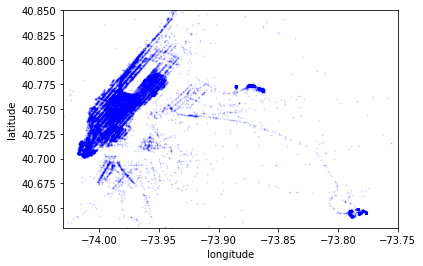

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.scatter(data['pickup_longitude'].values[:len(data)], data['pickup_latitude'].values[:len(data)],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Model Selection, Comparison and Cross Validation

## Exploratory Analysis

## Model Selection